#Load data

In [ ]:
import pandas as pd

comment_data_general_features = pd.read_csv(r'/content/drive/MyDrive/UNI/MSc/Thesis/comment_data_general_features.csv')

In [ ]:
comment_data_general_features.drop(comment_data_general_features.columns[0], axis=1, inplace=True)

In [ ]:
print(comment_data_general_features.head())

   pinned_f  votes_pos  votes_neg  votes_rel  is_root_comment  \
0      True        102         20         82             True   
1      True         30          2         28             True   
2     False          0          0          0             True   
3     False          3          2          1             True   
4     False          3          0          3             True   

   is_leaf_comment  level_in_tree  size_of_tree  height_of_tree  \
0            False              0            34               3   
1            False              0            14               6   
2             True              0             1               0   
3             True              0             1               0   
4             True              0             1               0   

   sentiment_prob_pos  ...  lexdiv_cttr  num_punct  cosine_1  num_words  \
0            0.004558  ...     4.435111         16  0.165136         99   
1            0.000004  ...     3.402069          5  0.10

#Prepare dataset

In [ ]:
# scale variables (sentiment and cosine)
comment_data_general_features['sentiment_prob_pos'] = comment_data_general_features['sentiment_prob_pos'] * 100
comment_data_general_features['sentiment_prob_neg'] = comment_data_general_features['sentiment_prob_neg'] * 100
comment_data_general_features['cosine_1'] = comment_data_general_features['cosine_1'] * 100


In [ ]:
import numpy as np

# Modify dataset
columns_to_select = [
    "sentiment_prob_pos", "sentiment_prob_neg",
    "lexdiv_cttr", "num_punct",
    "num_sentences",
    "SMOG_readability",
    "cosine_1",
    "hours_since_article",
    "is_leaf_comment", "is_root_comment", "size_of_tree", "height_of_tree", "level_in_tree",
    "all_replies", "second_person", "user_follower",
    "pinned_f",
    "votes_neg", "votes_pos"]

comment_features_ml = comment_data_general_features[columns_to_select]

# Indices of training, validation, and test observations
all_indices = np.arange(comment_features_ml.shape[0])
np.random.shuffle(all_indices)  # randomize

training_indices = all_indices[:round(len(all_indices) * 0.6)]  # 60%
test_indices = all_indices[round(len(all_indices) * 0.6):]  # 40%

#I. Upvotes

##Preparing the data

In [ ]:
# Remove "votes_rel" column from comment_features_ml
comment_features_up = comment_features_ml

# Get column names and number of columns
col_names_up = comment_features_up.columns
num_cols_up = len(comment_features_up.columns)

print(col_names_up)
print(num_cols_up)

Index(['sentiment_prob_pos', 'sentiment_prob_neg', 'lexdiv_cttr', 'num_punct',
       'num_sentences', 'SMOG_readability', 'cosine_1', 'hours_since_article',
       'is_leaf_comment', 'is_root_comment', 'size_of_tree', 'height_of_tree',
       'level_in_tree', 'all_replies', 'second_person', 'user_follower',
       'pinned_f', 'votes_neg', 'votes_pos'],
      dtype='object')
19


In [ ]:
comment_features_up.head()

,sentiment_prob_pos,sentiment_prob_neg,lexdiv_cttr,num_punct,num_sentences,SMOG_readability,cosine_1,hours_since_article,is_leaf_comment,is_root_comment,size_of_tree,height_of_tree,level_in_tree,all_replies,second_person,user_follower,pinned_f,votes_neg,votes_pos
0,0.455808,2.037735,4.435111,16,5,8.677078,16.513588,0.000000,False,True,34,3,0,32,False,6,True,20,102
1,0.000400,0.000488,3.402069,5,3,9.401754,10.451305,0.000000,False,True,14,6,0,12,False,28,True,2,30
2,2.518362,95.728326,5.151222,26,6,5.745967,6.427475,21.270278,True,True,1,0,0,0,False,2,False,0,0
3,0.000424,0.000823,1.918806,4,1,10.247449,4.873465,18.592222,True,True,1,0,0,0,False,14,False,2,3
4,0.130338,0.436271,2.236068,2,2,5.745967,1.817052,17.625556,True,True,1,0,0,0,False,5,False,0,3


##A. Negative Binomial regression model - upvotes

In [ ]:
y = comment_features_up.iloc[:, -1].values
X = comment_features_up.iloc[:, :-1]

In [ ]:
print(X.head())

   sentiment_prob_pos  sentiment_prob_neg  lexdiv_cttr  num_punct  \
0            0.455808            2.037735     4.435111         16   
1            0.000400            0.000488     3.402069          5   
2            2.518362           95.728326     5.151222         26   
3            0.000424            0.000823     1.918806          4   
4            0.130338            0.436271     2.236068          2   

   num_sentences  SMOG_readability   cosine_1  hours_since_article  \
0              5          8.677078  16.513588             0.000000   
1              3          9.401754  10.451305             0.000000   
2              6          5.745967   6.427475            21.270278   
3              1         10.247449   4.873465            18.592222   
4              2          5.745967   1.817052            17.625556   

   is_leaf_comment  is_root_comment  size_of_tree  height_of_tree  \
0            False             True            34               3   
1            False        

In [ ]:
print(y.shape)
print(X.shape)

(1203395,)
(1203395, 18)


In [ ]:
X['is_leaf_comment'] = X['is_leaf_comment'].astype('int')
X['is_root_comment'] = X['is_root_comment'].astype('int')
X['second_person'] = X['second_person'].astype('int')
X['pinned_f'] = X['pinned_f'].astype('int')

In [ ]:
X.dtypes

sentiment_prob_pos     float64
sentiment_prob_neg     float64
lexdiv_cttr            float64
num_punct                int64
num_sentences            int64
SMOG_readability       float64
cosine_1               float64
hours_since_article    float64
is_leaf_comment          int64
is_root_comment          int64
size_of_tree             int64
height_of_tree           int64
level_in_tree            int64
all_replies              int64
second_person            int64
user_follower            int64
pinned_f                 int64
votes_neg                int64
dtype: object

In [ ]:
import pandas as pd
import statsmodels.api as sm

# Fit the negative binomial regression model
model = sm.GLM(y, X, family=sm.families.NegativeBinomial())
result = model.fit()

# Print the summary of the regression
print(result.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:              1203395
Model:                            GLM   Df Residuals:                  1203377
Model Family:        NegativeBinomial   Df Model:                           17
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.0441e+06
Date:                Mon, 14 Aug 2023   Deviance:                   1.7700e+06
Time:                        19:50:53   Pearson chi2:                 7.08e+06
No. Iterations:                    17   Pseudo R-squ. (CS):             0.3831
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
sentiment_prob_pos      0.0013   4

In [ ]:
from statsmodels.iolib.summary2 import summary_col

# Create a dataframe from the summary
summary_df = summary_col([result])

# Print the resulting dataframe
print(summary_df)


                       y    
----------------------------
sentiment_prob_pos  0.0013  
                    (0.0000)
sentiment_prob_neg  0.0011  
                    (0.0000)
lexdiv_cttr         0.4382  
                    (0.0021)
num_punct           -0.0382 
                    (0.0002)
num_sentences       0.0138  
                    (0.0011)
SMOG_readability    0.0115  
                    (0.0004)
cosine_1            -0.0003 
                    (0.0002)
hours_since_article -0.0002 
                    (0.0000)
is_leaf_comment     0.0990  
                    (0.0021)
is_root_comment     0.9683  
                    (0.0027)
size_of_tree        0.0032  
                    (0.0001)
height_of_tree      0.1039  
                    (0.0006)
level_in_tree       -0.3178 
                    (0.0011)
all_replies         0.0055  
                    (0.0004)
second_person       0.1124  
                    (0.0036)
user_follower       0.0026  
                    (0.0000)
pinned_f     

##B. Random Forest

In [ ]:
# Dataset split
training_y = comment_features_up.iloc[training_indices, -1].values
training_X = comment_features_up.iloc[training_indices, :-1]
test_y = comment_features_up.iloc[test_indices, -1].values
test_X = comment_features_up.iloc[test_indices, :-1]

In [ ]:
print(training_y.shape)
print(training_X.shape)
print(test_y.shape)
print(test_X.shape)

(722037,)
(722037, 18)
(481358,)
(481358, 18)


In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(max_features = int(training_X.shape[1]/3),
                           criterion = "squared_error",
                           max_depth = 20,
                           verbose = 2)

# Train the model on training data
rf.fit(training_X, training_y)

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.8min


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

RandomForestRegressor(max_depth=20, max_features=6, verbose=2)

In [ ]:
# performance
# Use the forest's predict method on the test data
predictions = rf.predict(test_X)

from sklearn.metrics import mean_squared_error

# Calculate the mean squared error
mse = mean_squared_error(test_y, predictions)

print(f"Mean Squared Error: {mse:.2f}")

# Calculate the absolute errors
errors = abs(predictions - test_y)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.2s


Mean Squared Error: 138.29
Mean Absolute Error: 4.61 degrees.


###Feature importance

The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance.

Warning: impurity-based feature importances can be misleading for high cardinality features (many unique values). See sklearn.inspection.permutation_importance as an alternative.

In [ ]:
# feature importance

# Get feature importance scores
feature_importances = rf.feature_importances_

# Create a DataFrame to display feature importance scores
feature_importance_df = pd.DataFrame({'Feature': training_X.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importance
print(feature_importance_df)

                Feature  Importance
16             pinned_f    0.287837
7   hours_since_article    0.086604
13          all_replies    0.080810
10         size_of_tree    0.065138
0    sentiment_prob_pos    0.057368
17            votes_neg    0.056850
1    sentiment_prob_neg    0.053178
6              cosine_1    0.051179
2           lexdiv_cttr    0.046230
15        user_follower    0.044086
5      SMOG_readability    0.036251
3             num_punct    0.035464
11       height_of_tree    0.028416
12        level_in_tree    0.023079
9       is_root_comment    0.019856
4         num_sentences    0.018092
8       is_leaf_comment    0.005133
14        second_person    0.004429


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

#permutation-importance
result = permutation_importance(rf, test_X, test_y, n_repeats=1, random_state=42)

# Create a DataFrame to display permutation importances
permutation_importance_df = pd.DataFrame({'Feature': training_X.columns, 'Importance': result.importances_mean})

# Sort the DataFrame by importance in descending order
permutation_importance_df = permutation_importance_df.sort_values(by='Importance', ascending=False)

# Print the permutation importances
print(permutation_importance_df)

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.9s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.5s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.4s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.3s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    7.2s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.2s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   13.9s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    4.9s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    4.9s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    6.8s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    4.8s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    4.9s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    4.8s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.4s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Do

                Feature  Importance
16             pinned_f    0.331677
10         size_of_tree    0.163102
13          all_replies    0.064095
7   hours_since_article    0.062364
9       is_root_comment    0.052853
12        level_in_tree    0.047650
17            votes_neg    0.035087
11       height_of_tree    0.023838
8       is_leaf_comment    0.019050
2           lexdiv_cttr    0.007388
15        user_follower    0.004437
5      SMOG_readability    0.003268
0    sentiment_prob_pos    0.002950
6              cosine_1    0.002583
4         num_sentences    0.002273
1    sentiment_prob_neg    0.002118
14        second_person    0.001417
3             num_punct    0.001380


In [ ]:
permutation_importance_df

,Feature,Importance
16,pinned_f,0.331677
10,size_of_tree,0.163102
13,all_replies,0.064095
7,hours_since_article,0.062364
9,is_root_comment,0.052853
12,level_in_tree,0.047650
17,votes_neg,0.035087
11,height_of_tree,0.023838
8,is_leaf_comment,0.019050
2,lexdiv_cttr,0.007388


In [ ]:
feature_importance_df.columns = ['Feature', 'Gini']
permutation_importance_df.columns = ['Feature', 'Permutation']

# Merge the DataFrames based on the 'common_column'
merged_df = pd.merge(feature_importance_df, permutation_importance_df, on='Feature')

In [ ]:
merged_df

,Feature,Gini,Permutation
0,pinned_f,0.287837,0.331677
1,hours_since_article,0.086604,0.062364
2,all_replies,0.080810,0.064095
3,size_of_tree,0.065138,0.163102
4,sentiment_prob_pos,0.057368,0.002950
5,votes_neg,0.056850,0.035087
6,sentiment_prob_neg,0.053178,0.002118
7,cosine_1,0.051179,0.002583
8,lexdiv_cttr,0.046230,0.007388
9,user_follower,0.044086,0.004437


import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(merged_df, *['Gini'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(merged_df, *['Permutation'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(merged_df, *['Gini'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(merged_df, *['Permutation'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plots(df, colname_pairs, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * 10 * figscale, 10 * figscale))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha, ax=ax)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(merged_df, *[[['Gini', 'Permutation']]], **{})
chart

#II. Downvotes

##Preparing the data

In [ ]:
import numpy as np

# Modify dataset
columns_to_select = [
    "sentiment_prob_pos", "sentiment_prob_neg",
    "lexdiv_cttr", "num_punct",
    "num_sentences",
    "SMOG_readability",
    "cosine_1",
    "hours_since_article",
    "is_leaf_comment", "is_root_comment", "size_of_tree", "height_of_tree", "level_in_tree",
    "all_replies", "second_person", "user_follower",
    "pinned_f",
    "votes_pos", "votes_neg"]

comment_features_ml = comment_data_general_features[columns_to_select]

In [ ]:

comment_features_down = comment_features_ml

# Get column names and number of columns
col_names_up = comment_features_down.columns
num_cols_up = len(comment_features_down.columns)

print(col_names_up)
print(num_cols_up)

Index(['sentiment_prob_pos', 'sentiment_prob_neg', 'lexdiv_cttr', 'num_punct',
       'num_sentences', 'SMOG_readability', 'cosine_1', 'hours_since_article',
       'is_leaf_comment', 'is_root_comment', 'size_of_tree', 'height_of_tree',
       'level_in_tree', 'all_replies', 'second_person', 'user_follower',
       'pinned_f', 'votes_pos', 'votes_neg'],
      dtype='object')
19


In [ ]:
comment_features_down.head()

,sentiment_prob_pos,sentiment_prob_neg,lexdiv_cttr,num_punct,num_sentences,SMOG_readability,cosine_1,hours_since_article,is_leaf_comment,is_root_comment,size_of_tree,height_of_tree,level_in_tree,all_replies,second_person,user_follower,pinned_f,votes_pos,votes_neg
0,0.455808,2.037735,4.435111,16,5,8.677078,16.513588,0.000000,False,True,34,3,0,32,False,6,True,102,20
1,0.000400,0.000488,3.402069,5,3,9.401754,10.451305,0.000000,False,True,14,6,0,12,False,28,True,30,2
2,2.518362,95.728326,5.151222,26,6,5.745967,6.427475,21.270278,True,True,1,0,0,0,False,2,False,0,0
3,0.000424,0.000823,1.918806,4,1,10.247449,4.873465,18.592222,True,True,1,0,0,0,False,14,False,3,2
4,0.130338,0.436271,2.236068,2,2,5.745967,1.817052,17.625556,True,True,1,0,0,0,False,5,False,3,0


##A. Negative Binomial regression model - downvotes

In [ ]:
y = comment_features_down.iloc[:, -1].values
X = comment_features_down.iloc[:, :-1]

In [ ]:
print(X.head())

   sentiment_prob_pos  sentiment_prob_neg  lexdiv_cttr  num_punct  \
0            0.455808            2.037735     4.435111         16   
1            0.000400            0.000488     3.402069          5   
2            2.518362           95.728326     5.151222         26   
3            0.000424            0.000823     1.918806          4   
4            0.130338            0.436271     2.236068          2   

   num_sentences  SMOG_readability   cosine_1  hours_since_article  \
0              5          8.677078  16.513588             0.000000   
1              3          9.401754  10.451305             0.000000   
2              6          5.745967   6.427475            21.270278   
3              1         10.247449   4.873465            18.592222   
4              2          5.745967   1.817052            17.625556   

   is_leaf_comment  is_root_comment  size_of_tree  height_of_tree  \
0            False             True            34               3   
1            False        

In [ ]:
print(y)

[20  2  0 ...  0  0  0]


In [ ]:
print(y.shape)
print(X.shape)

(1203395,)
(1203395, 18)


In [ ]:
X['is_leaf_comment'] = X['is_leaf_comment'].astype('int')
X['is_root_comment'] = X['is_root_comment'].astype('int')
X['second_person'] = X['second_person'].astype('int')
X['pinned_f'] = X['pinned_f'].astype('int')

In [ ]:
X.dtypes

sentiment_prob_pos     float64
sentiment_prob_neg     float64
lexdiv_cttr            float64
num_punct                int64
num_sentences            int64
SMOG_readability       float64
cosine_1               float64
hours_since_article    float64
is_leaf_comment          int64
is_root_comment          int64
size_of_tree             int64
height_of_tree           int64
level_in_tree            int64
all_replies              int64
second_person            int64
user_follower            int64
pinned_f                 int64
votes_pos                int64
dtype: object

In [ ]:
import pandas as pd
import statsmodels.api as sm

# Fit the negative binomial regression model
model = sm.GLM(y, X, family=sm.families.NegativeBinomial())
result = model.fit()

# Print the summary of the regression
print(result.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:              1203395
Model:                            GLM   Df Residuals:                  1203377
Model Family:        NegativeBinomial   Df Model:                           17
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.6098e+06
Date:                Mon, 14 Aug 2023   Deviance:                   1.6997e+06
Time:                        19:58:00   Pearson chi2:                 1.21e+10
No. Iterations:                    20   Pseudo R-squ. (CS):             0.4376
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
sentiment_prob_pos     -0.0017   6

In [ ]:
from statsmodels.iolib.summary2 import summary_col

# Create a dataframe from the summary
summary_df = summary_col([result])

# Print the resulting dataframe
print(summary_df)


                       y    
----------------------------
sentiment_prob_pos  -0.0017 
                    (0.0001)
sentiment_prob_neg  0.0009  
                    (0.0000)
lexdiv_cttr         0.1603  
                    (0.0027)
num_punct           -0.0299 
                    (0.0003)
num_sentences       0.0403  
                    (0.0014)
SMOG_readability    0.0147  
                    (0.0005)
cosine_1            -0.0113 
                    (0.0003)
hours_since_article -0.0032 
                    (0.0000)
is_leaf_comment     -1.0364 
                    (0.0028)
is_root_comment     0.4636  
                    (0.0036)
size_of_tree        0.0061  
                    (0.0001)
height_of_tree      0.0677  
                    (0.0007)
level_in_tree       -0.2667 
                    (0.0014)
all_replies         0.0699  
                    (0.0004)
second_person       0.2790  
                    (0.0045)
user_follower       -0.0005 
                    (0.0000)
pinned_f     

##B. Random Forest

In [ ]:
# Dataset split
training_y = comment_features_down.iloc[training_indices, -1].values
training_X = comment_features_down.iloc[training_indices, :-1]
test_y = comment_features_down.iloc[test_indices, -1].values
test_X = comment_features_down.iloc[test_indices, :-1]

In [ ]:
print(training_y.shape)
print(training_X.shape)
print(test_y.shape)
print(test_X.shape)

(722037,)
(722037, 18)
(481358,)
(481358, 18)


In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(max_features = int(training_X.shape[1]/3),
                           criterion = "squared_error",
                           max_depth = 20,
                           verbose = 2)

# Train the model on training data
rf.fit(training_X, training_y)

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.9min


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

RandomForestRegressor(max_depth=20, max_features=6, verbose=2)

In [ ]:
# performance
# Use the forest's predict method on the test data
predictions = rf.predict(test_X)

from sklearn.metrics import mean_squared_error

# Calculate the mean squared error
mse = mean_squared_error(test_y, predictions)

print(f"Mean Squared Error: {mse:.2f}")

# Calculate the absolute errors
errors = abs(predictions - test_y)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    4.9s


Mean Squared Error: 26.33
Mean Absolute Error: 1.74 degrees.


###Feature importance

In [ ]:
# feature importance

# Get feature importance scores
feature_importances = rf.feature_importances_

# Create a DataFrame to display feature importance scores
feature_importance_df = pd.DataFrame({'Feature': training_X.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importance
print(feature_importance_df)

                Feature  Importance
13          all_replies    0.166431
10         size_of_tree    0.120485
11       height_of_tree    0.075894
2           lexdiv_cttr    0.074261
17            votes_pos    0.069827
1    sentiment_prob_neg    0.066076
7   hours_since_article    0.062740
0    sentiment_prob_pos    0.061193
5      SMOG_readability    0.059883
6              cosine_1    0.054800
3             num_punct    0.052476
15        user_follower    0.039027
16             pinned_f    0.034023
4         num_sentences    0.025649
8       is_leaf_comment    0.013446
14        second_person    0.011684
12        level_in_tree    0.007144
9       is_root_comment    0.004959


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

#permutation-importance
result = permutation_importance(rf, test_X, test_y, n_repeats=1, random_state=42)

# Create a DataFrame to display permutation importances
permutation_importance_df = pd.DataFrame({'Feature': training_X.columns, 'Importance': result.importances_mean})

# Sort the DataFrame by importance in descending order
permutation_importance_df = permutation_importance_df.sort_values(by='Importance', ascending=False)

# Print the permutation importances
print(permutation_importance_df)

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    4.5s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    4.4s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    4.3s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    4.4s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    4.6s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    4.5s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    4.4s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    4.3s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    4.3s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    4.6s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    4.5s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    4.2s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    4.3s
[Parallel(n_jobs=1)]: Do

                Feature  Importance
11       height_of_tree    0.358590
10         size_of_tree    0.357013
13          all_replies    0.220462
8       is_leaf_comment    0.171564
2           lexdiv_cttr    0.144423
3             num_punct    0.070542
17            votes_pos    0.068302
16             pinned_f    0.047719
12        level_in_tree    0.033483
9       is_root_comment    0.021370
14        second_person    0.012309
1    sentiment_prob_neg    0.010855
4         num_sentences    0.008618
6              cosine_1    0.007847
5      SMOG_readability    0.005727
0    sentiment_prob_pos    0.005187
7   hours_since_article    0.003540
15        user_follower    0.000906


In [ ]:
feature_importance_df.columns = ['Feature', 'Gini']
permutation_importance_df.columns = ['Feature', 'Permutation']

# Merge the DataFrames based on the 'common_column'
merged_df = pd.merge(feature_importance_df, permutation_importance_df, on='Feature')

In [ ]:
merged_df

,Feature,Gini,Permutation
0,all_replies,0.166431,0.220462
1,size_of_tree,0.120485,0.357013
2,height_of_tree,0.075894,0.358590
3,lexdiv_cttr,0.074261,0.144423
4,votes_pos,0.069827,0.068302
5,sentiment_prob_neg,0.066076,0.010855
6,hours_since_article,0.062740,0.003540
7,sentiment_prob_pos,0.061193,0.005187
8,SMOG_readability,0.059883,0.005727
9,cosine_1,0.054800,0.007847


#[OLD]III. Relative user votes

##Preparing the data

In [ ]:
import numpy as np

# Modify dataset
columns_to_select = [
    "sentiment_prob_pos", "sentiment_prob_neg", "sentiment_prob_neu",
    "lexdiv_cttr", "num_punct", "num_words", "num_sentences",
    "SMOG_readability", "word_to_sent",
    "cosine_1",
    "hours_since_article",
    "is_leaf_comment", "is_root_comment", "size_of_tree", "height_of_tree", "level_in_tree",
    "all_replies", "second_person", "user_follower",
    "pinned_f",
    "votes_pos","votes_neg", "votes_rel"]

comment_features_ml = comment_data_general_features[columns_to_select]

In [ ]:
comment_features_rel = comment_features_ml.drop(columns=["votes_pos", "votes_neg"])

# Get column names and number of columns
col_names_rel = comment_features_rel.columns
num_cols_rel = len(comment_features_rel.columns)

print(col_names_rel)
print(num_cols_rel)

Index(['sentiment_prob_pos', 'sentiment_prob_neg', 'sentiment_prob_neu',
       'lexdiv_cttr', 'num_punct', 'num_words', 'num_sentences',
       'SMOG_readability', 'word_to_sent', 'cosine_1', 'hours_since_article',
       'is_leaf_comment', 'is_root_comment', 'size_of_tree', 'height_of_tree',
       'level_in_tree', 'all_replies', 'second_person', 'user_follower',
       'pinned_f', 'votes_rel'],
      dtype='object')
21


In [ ]:
comment_features_rel.head()

,sentiment_prob_pos,sentiment_prob_neg,sentiment_prob_neu,lexdiv_cttr,num_punct,num_words,num_sentences,SMOG_readability,word_to_sent,cosine_1,...,is_leaf_comment,is_root_comment,size_of_tree,height_of_tree,level_in_tree,all_replies,second_person,user_follower,pinned_f,votes_rel
0,0.004558,0.020377,0.975065,4.435111,16,99,5,8.677078,19.800000,0.165136,...,False,True,34,3,0,32,False,6,True,82
1,0.000004,0.000005,0.999991,3.402069,5,47,3,9.401754,15.666667,0.104513,...,False,True,14,6,0,12,False,28,True,28
2,0.025184,0.957283,0.017533,5.151222,26,103,6,5.745967,17.166667,0.064275,...,True,True,1,0,0,0,False,2,False,0
3,0.000004,0.000008,0.999987,1.918806,4,17,1,10.247449,17.000000,0.048735,...,True,True,1,0,0,0,False,14,False,1
4,0.001303,0.004363,0.994334,2.236068,2,26,2,5.745967,13.000000,0.018171,...,True,True,1,0,0,0,False,5,False,3


##A. Linear regression

In [ ]:
y = comment_features_rel.iloc[:, -1].values
X = comment_features_rel.iloc[:, :-1]

In [ ]:
print(y.shape)
print(X.shape)

(1203395,)
(1203395, 20)


In [ ]:
X['is_leaf_comment'] = X['is_leaf_comment'].astype('int')
X['is_root_comment'] = X['is_root_comment'].astype('int')
X['second_person'] = X['second_person'].astype('int')
X['pinned_f'] = X['pinned_f'].astype('int')

In [ ]:
X_with_const = sm.add_constant(X)

In [ ]:
model = sm.OLS(y, X_with_const)
result = model.fit()

# Print the summary of the regression
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                 1.605e+04
Date:                Mon, 14 Aug 2023   Prob (F-statistic):               0.00
Time:                        13:02:58   Log-Likelihood:            -4.8824e+06
No. Observations:             1203395   AIC:                         9.765e+06
Df Residuals:                 1203374   BIC:                         9.765e+06
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                8.304e+04   2

##B. Random Forest

In [ ]:
# Dataset split
training_y = comment_features_rel.iloc[training_indices, -1].values
training_X = comment_features_rel.iloc[training_indices, :-1]
test_y = comment_features_rel.iloc[test_indices, -1].values
test_X = comment_features_rel.iloc[test_indices, :-1]

In [ ]:
print(training_y.shape)
print(training_X.shape)
print(test_y.shape)
print(test_X.shape)

(722037,)
(722037, 20)
(481358,)
(481358, 20)


In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(max_features = int(training_X.shape[1]/3),
                           criterion = "squared_error",
                           max_depth = 20,
                           verbose = 2)

# Train the model on training data
rf.fit(training_X, training_y)

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  2.0min


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

RandomForestRegressor(max_depth=20, max_features=6, verbose=2)

In [ ]:
# performance
# Use the forest's predict method on the test data
predictions = rf.predict(test_X)

from sklearn.metrics import mean_squared_error

# Calculate the mean squared error
mse = mean_squared_error(test_y, predictions)

print(f"Mean Squared Error: {mse:.2f}")

# Calculate the absolute errors
errors = abs(predictions - test_y)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.2s


Mean Squared Error: 184.79
Mean Absolute Error: 5.04 degrees.


###Feature importance

In [ ]:
# feature importance

# Get feature importance scores
feature_importances = rf.feature_importances_

# Create a DataFrame to display feature importance scores
feature_importance_df = pd.DataFrame({'Feature': training_X.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importance
print(feature_importance_df)

                Feature  Importance
19             pinned_f    0.216704
10  hours_since_article    0.088731
13         size_of_tree    0.072396
16          all_replies    0.065094
0    sentiment_prob_pos    0.058877
1    sentiment_prob_neg    0.052604
2    sentiment_prob_neu    0.049379
8          word_to_sent    0.049287
9              cosine_1    0.049221
5             num_words    0.045893
3           lexdiv_cttr    0.045567
18        user_follower    0.041447
7      SMOG_readability    0.041304
4             num_punct    0.036767
14       height_of_tree    0.030758
6         num_sentences    0.019519
15        level_in_tree    0.017604
12      is_root_comment    0.012513
17        second_person    0.003444
11      is_leaf_comment    0.002891


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

#permutation-importance
result = permutation_importance(rf, test_X, test_y, n_repeats=1, random_state=42)

# Create a DataFrame to display permutation importances
permutation_importance_df = pd.DataFrame({'Feature': training_X.columns, 'Importance': result.importances_mean})

# Sort the DataFrame by importance in descending order
permutation_importance_df = permutation_importance_df.sort_values(by='Importance', ascending=False)

# Print the permutation importances
print(permutation_importance_df)

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    4.7s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    4.6s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    4.6s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    4.6s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    4.6s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.2s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.5s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.2s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.3s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    4.7s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    4.6s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    4.6s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    4.6s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    4.6s
[Parallel(n_jobs=1)]: Do

                Feature  Importance
19             pinned_f    0.265120
10  hours_since_article    0.096064
13         size_of_tree    0.090362
15        level_in_tree    0.046077
12      is_root_comment    0.035718
11      is_leaf_comment    0.028979
16          all_replies    0.018662
14       height_of_tree    0.014732
5             num_words    0.009333
4             num_punct    0.005151
3           lexdiv_cttr    0.004457
18        user_follower    0.004043
7      SMOG_readability    0.004017
2    sentiment_prob_neu    0.002980
9              cosine_1    0.001511
8          word_to_sent    0.001446
0    sentiment_prob_pos    0.000895
17        second_person    0.000852
1    sentiment_prob_neg   -0.000617
6         num_sentences   -0.002283


#IV. Classification of pinned status

##Preparing the data

In [ ]:
import numpy as np

# Modify dataset
columns_to_select = [
    "sentiment_prob_pos", "sentiment_prob_neg",
    "lexdiv_cttr", "num_punct",
    "num_sentences",
    "SMOG_readability",
    "cosine_1",
    "hours_since_article",
    "is_leaf_comment", "is_root_comment", "size_of_tree", "height_of_tree", "level_in_tree",
    "all_replies", "second_person", "user_follower",
    "votes_pos", "votes_neg",
    "pinned_f"]

comment_features_ml = comment_data_general_features[columns_to_select]

In [ ]:
comment_features_pin = comment_features_ml

# Get column names and number of columns
col_names_pin = comment_features_pin.columns
num_cols_pin = len(comment_features_pin.columns)

print(col_names_pin)
print(num_cols_pin)

Index(['sentiment_prob_pos', 'sentiment_prob_neg', 'lexdiv_cttr', 'num_punct',
       'num_sentences', 'SMOG_readability', 'cosine_1', 'hours_since_article',
       'is_leaf_comment', 'is_root_comment', 'size_of_tree', 'height_of_tree',
       'level_in_tree', 'all_replies', 'second_person', 'user_follower',
       'votes_pos', 'votes_neg', 'pinned_f'],
      dtype='object')
19


In [ ]:
comment_features_pin.head()

,sentiment_prob_pos,sentiment_prob_neg,lexdiv_cttr,num_punct,num_sentences,SMOG_readability,cosine_1,hours_since_article,is_leaf_comment,is_root_comment,size_of_tree,height_of_tree,level_in_tree,all_replies,second_person,user_follower,votes_pos,votes_neg,pinned_f
0,0.455808,2.037735,4.435111,16,5,8.677078,16.513588,0.000000,False,True,34,3,0,32,False,6,102,20,True
1,0.000400,0.000488,3.402069,5,3,9.401754,10.451305,0.000000,False,True,14,6,0,12,False,28,30,2,True
2,2.518362,95.728326,5.151222,26,6,5.745967,6.427475,21.270278,True,True,1,0,0,0,False,2,0,0,False
3,0.000424,0.000823,1.918806,4,1,10.247449,4.873465,18.592222,True,True,1,0,0,0,False,14,3,2,False
4,0.130338,0.436271,2.236068,2,2,5.745967,1.817052,17.625556,True,True,1,0,0,0,False,5,3,0,False


##B. Random Forest

In [ ]:
# Dataset split
training_y = comment_features_pin.iloc[training_indices, -1].values
training_X = comment_features_pin.iloc[training_indices, :-1]
test_y = comment_features_pin.iloc[test_indices, -1].values
test_X = comment_features_pin.iloc[test_indices, :-1]

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the outcome variable
training_y = label_encoder.fit_transform(training_y)
test_y = label_encoder.fit_transform(test_y)

In [ ]:
training_y

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
training_X

In [ ]:
print(training_y.shape)
print(training_X.shape)
print(test_y.shape)
print(test_X.shape)

(722037,)
(722037, 18)
(481358,)
(481358, 18)


In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(max_features = int(np.sqrt(training_X.shape[1])),
                           criterion = "entropy",
                           max_depth = 20,
                           verbose = 2)

# Train the model on training data
rf.fit(training_X, training_y)

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   42.8s


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

RandomForestClassifier(criterion='entropy', max_depth=20, max_features=4,
                       verbose=2)

In [ ]:
# performance
# Use the forest's predict method on the test data
predictions = rf.predict(test_X)

from sklearn.metrics import f1_score

# Calculate the F1 score
f1 = f1_score(test_y, predictions)

print("F1 Score:", f1)

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.4s


F1 Score: 0.7745358090185677


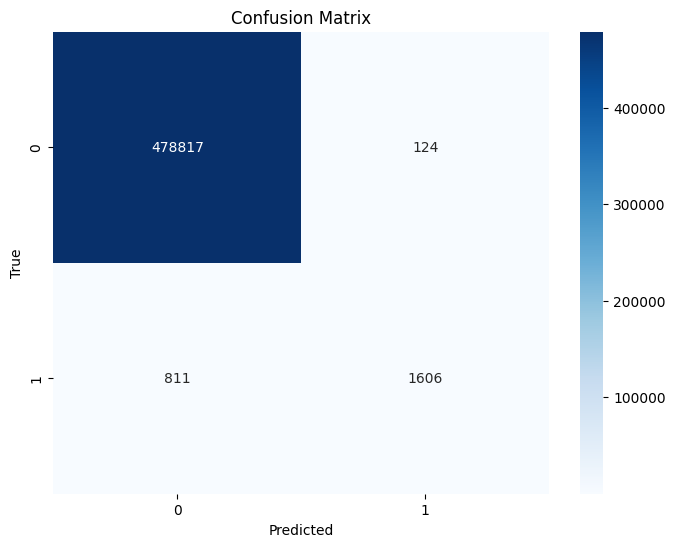

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create a confusion matrix
cm = confusion_matrix(test_y, predictions)

# Create a DataFrame for better visualization
cm_df = pd.DataFrame(cm)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

###Feature importance

In [ ]:
# feature importance

# Get feature importance scores
feature_importances = rf.feature_importances_

# Create a DataFrame to display feature importance scores
feature_importance_df = pd.DataFrame({'Feature': training_X.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importance
print(feature_importance_df)

                Feature  Importance
16            votes_pos    0.349084
10         size_of_tree    0.126461
13          all_replies    0.114656
9       is_root_comment    0.050256
12        level_in_tree    0.047818
17            votes_neg    0.046747
7   hours_since_article    0.039626
11       height_of_tree    0.033772
8       is_leaf_comment    0.033746
0    sentiment_prob_pos    0.027299
6              cosine_1    0.024982
2           lexdiv_cttr    0.024292
1    sentiment_prob_neg    0.022783
5      SMOG_readability    0.016314
3             num_punct    0.016082
15        user_follower    0.015736
4         num_sentences    0.008832
14        second_person    0.001515


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

#permutation-importance
result = permutation_importance(rf, test_X, test_y, n_repeats=1, random_state=42)

# Create a DataFrame to display permutation importances
permutation_importance_df = pd.DataFrame({'Feature': training_X.columns, 'Importance': result.importances_mean})

# Sort the DataFrame by importance in descending order
permutation_importance_df = permutation_importance_df.sort_values(by='Importance', ascending=False)

# Print the permutation importances
print(permutation_importance_df)

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Do

                Feature  Importance
10         size_of_tree    0.147036
8       is_leaf_comment    0.062405
13          all_replies    0.002665
16            votes_pos    0.002372
9       is_root_comment    0.000848
12        level_in_tree    0.000798
11       height_of_tree    0.000686
7   hours_since_article    0.000299
17            votes_neg    0.000233
6              cosine_1    0.000052
2           lexdiv_cttr    0.000048
5      SMOG_readability    0.000019
3             num_punct    0.000012
4         num_sentences    0.000000
14        second_person    0.000000
1    sentiment_prob_neg   -0.000004
0    sentiment_prob_pos   -0.000010
15        user_follower   -0.000012


In [ ]:
feature_importance_df.columns = ['Feature', 'Gini']
permutation_importance_df.columns = ['Feature', 'Permutation']

# Merge the DataFrames based on the 'common_column'
merged_df = pd.merge(feature_importance_df, permutation_importance_df, on='Feature')

In [ ]:
merged_df

,Feature,Gini,Permutation
0,votes_pos,0.349084,0.002372
1,size_of_tree,0.126461,0.147036
2,all_replies,0.114656,0.002665
3,is_root_comment,0.050256,0.000848
4,level_in_tree,0.047818,0.000798
5,votes_neg,0.046747,0.000233
6,hours_since_article,0.039626,0.000299
7,height_of_tree,0.033772,0.000686
8,is_leaf_comment,0.033746,0.062405
9,sentiment_prob_pos,0.027299,-0.000010
